# Path 1: PM Strategy Execution & Completion Analysis
## INSY6500 - PM Analysis Project

**Analyst:** Mike Moyer

**Research Question:** *How do different departments approach preventative maintenance? Does it reveal anything about their operational philosophy?*

**Approach:** This notebook follows the EDA workflow to analyze the relationship between different departments and their planned PM activities.

---

## Phase 0 - Data Loading and Check

### 0.1 Setup & Data Loading

Import required libraries and load both datasets using the approach from the data loader template.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

print("Libraries imported")

Libraries imported


### 0.2 Define Data Path

In [2]:
# Define data directory
DATA_DIR = Path('../data')

# Define file paths
FORECAST_FILE = DATA_DIR / '103ki_pm_forecast.csv'

### 0.3 Load Forecast Data 

Scheduled PM activities for the coming fiscal year.

In [3]:
# Load future workload forecast data
df_forecast = pd.read_csv(FORECAST_FILE, 
                        encoding='cp1252',
                        parse_dates = ['DUE_DATE'],
                        dtype={
                            'INTERVAL': 'category',
                            'JOB_TYPE': 'category',
                            'LABOR_CRAFT': 'category',
                            'PMSCOPETYPE': 'category',
                            'DEPT': 'category',
                            'DEPT_NAME': 'category',
                            'DEPT_TYPE' : 'category',
                            'PLANT' : 'category',
                            'LINE' : 'category',
                            'ZONENAME' : 'category',
                            'PROCESSNAME' : 'category'
                        })
print(f"Forecast data shape: {df_forecast.shape[0]:,} rows, {df_forecast.shape[1]} columns")

Forecast data shape: 99,983 rows, 23 columns


In [4]:
# Quick preview
print("First 3 rows of Forecast data:")
display(df_forecast.head(3))

First 3 rows of Forecast data:


,DUE_DATE,PMNUM,COUNTKEY,PMDESCRIPTION,INTERVAL,FORECASTJP,JOB_TYPE,LABOR_CRAFT,PLANNED_LABORERS,PLANNED_LABOR_HRS,...,PMSCOPETYPE,LOCATION,LOCATIONDESC,PLANT,DEPT,DEPT_NAME,DEPT_TYPE,LINE,ZONENAME,PROCESSNAME
0,2026-04-01,PM104088,2026-04-01-PM104088,LP DIE CAST MACHINE #4 PM - M,1-MONTHS,JP211217,INSPECTION,ESTMULT,1.0,1.750000,...,ASSET,3DCLCAA4XXMC,Casting Die Cast Machine 4 Machine,3,3DC,DIE CAST,DC,L,LP Casting,Casting Die Cast Machine 4
1,2026-04-01,PM104114,2026-04-01-PM104114,LPDC #1 PF DEBURR STATION 1M PM,1-MONTHS,JP211160,INSPECTION,ESTMULT,1.0,0.500000,...,ASSET,3DCLPF01XXPF,Pre-finish Line 1 Pre-finish,3,3DC,DIE CAST,DC,L,Pre-finish,Pre-finish Line 1
2,2026-04-01,PM104116,2026-04-01-PM104116,LPDC #1 PF INSPECTION STATION PM,1-MONTHS,JP211164,INSPECTION,ESTMULT,1.0,0.333333,...,ASSET,3DCLPF01XXPF,Pre-finish Line 1 Pre-finish,3,3DC,DIE CAST,DC,L,Pre-finish,Pre-finish Line 1


In [5]:
#quick data type / info & nun-null check
print("\n Data Types and Non-Null Counts:")
df_forecast.info()


 Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99983 entries, 0 to 99982
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DUE_DATE                99983 non-null  datetime64[ns]
 1   PMNUM                   99983 non-null  object        
 2   COUNTKEY                99983 non-null  object        
 3   PMDESCRIPTION           99983 non-null  object        
 4   INTERVAL                99983 non-null  category      
 5   FORECASTJP              99910 non-null  object        
 6   JOB_TYPE                99906 non-null  category      
 7   LABOR_CRAFT             92101 non-null  category      
 8   PLANNED_LABORERS        99154 non-null  float64       
 9   PLANNED_LABOR_HRS       99154 non-null  float64       
 10  TOTAL_MATERIAL_COST     1932 non-null   float64       
 11  TASK_COUNT              99983 non-null  int64         
 12  TOTAL_TASK_D

In [6]:
df_forecast.describe()

,DUE_DATE,PLANNED_LABORERS,PLANNED_LABOR_HRS,TOTAL_MATERIAL_COST,TASK_COUNT,TOTAL_TASK_DESC_LENGTH
count,99983,99154.000000,99154.000000,1932.000000,99983.000000,99879.000000
mean,2026-10-07 09:22:25.800785920,1.083264,1.758899,4252.804974,13.213386,631.310836
min,2026-04-01 00:00:00,1.000000,0.000000,0.630000,0.000000,3.000000
25%,2026-07-01 00:00:00,1.000000,0.500000,17.440000,5.000000,166.000000
50%,2026-09-30 00:00:00,1.000000,1.000000,205.740000,8.000000,346.000000
75%,2026-12-28 00:00:00,1.000000,1.750000,653.860000,15.000000,638.000000
max,2027-03-30 00:00:00,20.000000,499.750000,876095.000000,425.000000,16942.000000
std,NaN,0.867851,9.369430,40696.001503,15.315923,856.198784


## Phase I - Foundations

**Focus:** Data prep & Feature Engineering

1. Parse `INTERVAL` into frequency groups
2. Create a Job Plan Complexity metric
3. Overall Summary Statistics

---
### 1.1 Explore the `Interval` Column

In [7]:
print("="*80)
print("INTERVAL FIELD EXPLORATION")
print("="*80)

# 1. Unique interval values and their frequency
print("\n-> Unique Interval Values:")
interval_counts = df_forecast['INTERVAL'].value_counts().sort_index()
print(f"\n   Total unique intervals: {df_forecast['INTERVAL'].nunique()}")
print("\n   Top 20 most common intervals:")
display(interval_counts.head(20).to_frame())

# 2. What units are used?
print("\n-> Units Found in Interval Field:")
# Extract the unit part (everything after the dash)
units = df_forecast['INTERVAL'].str.extract(r'-([A-Z]+)$')[0].value_counts()
display(units.to_frame(name='count'))

# 3. Full sorted list for reference
# Extract numeric part
df_forecast['interval_number'] = df_forecast['INTERVAL'].str.extract(r'^(\d+)-')[0].astype(float)
df_forecast['interval_unit'] = df_forecast['INTERVAL'].str.extract(r'-([A-Z]+)$')[0]
print("\n-> Complete Interval List (sorted by unit then number):")
all_intervals = df_forecast.groupby(['interval_unit', 'interval_number']).size().reset_index(name='count')
all_intervals = all_intervals.sort_values(['interval_unit', 'interval_number'])
display(all_intervals)

# Clean up temporary columns
df_forecast = df_forecast.drop(['interval_number', 'interval_unit'], axis=1)

INTERVAL FIELD EXPLORATION

-> Unique Interval Values:

   Total unique intervals: 47

   Top 20 most common intervals:


,count
INTERVAL,
1-DAYS,5980
1-MONTHS,33092
1-WEEKS,17475
1-YEARS,4811
10-WEEKS,5
10-YEARS,21
12-MONTHS,318
12-WEEKS,5
13-WEEKS,128



-> Units Found in Interval Field:


,count
0,
MONTHS,63927
WEEKS,21043
DAYS,9035
YEARS,5978



-> Complete Interval List (sorted by unit then number):


,interval_unit,interval_number,count
0,DAYS,1.0,5980
1,DAYS,6.0,156
2,DAYS,7.0,1863
3,DAYS,14.0,78
4,DAYS,21.0,68
5,DAYS,28.0,39
6,DAYS,32.0,11
7,DAYS,40.0,36
8,DAYS,45.0,658
9,DAYS,60.0,60


In [8]:
# Save interval analysis for reference
OUTPUT_DIR = Path('../outputs')
OUTPUT_DIR.mkdir(exist_ok=True)

# Save as both pickle and CSV
all_intervals.to_pickle(OUTPUT_DIR / 'interval_analysis.pkl')
all_intervals.to_csv(OUTPUT_DIR / 'interval_analysis.csv', index=False)

#### Overlaps and Observations

Its clear we have a vast range of intervals. Even though there are limited choices of interval unit, when it is combined with integer frequency, the combination of options allows for a wide range of interval catergories. I would like to simplify this for research by parsing them into larger categories. 


#### Parsing Strategy
To overcome these differences in text / yet similarities in frequence I will reparse the data with by converting the Frequency Unit to days and multiply them by the frequency to normalize their frequency.  

The Conversion will be 

```python
conversion = {
    'DAYS': 1,
    'WEEKS': 7,
    'MONTHS': 30.42,  # Average month length
    'YEARS': 365.25   # Account for leap years
}
```

The Frequency Bands will be defined as such: 

|Band|Days|Note|
|---|---|---|
|Daily:| < 4 | Clear daily or sub-weekly activities |
|Weekly:| 4-10 | "once-a-week" bucket |
|Biweekly:| 11-20 | Greater than once a week, but less than every 2 weeks |
|Monthly:| 21-45 | "roughly once a month" concept, captures odd 45 day frequency intervals |
|Bi-Monthly| 46-75 | roughly every other month |
|Quarterly:| 76-135 | roughly every 3 - 4 months |
|Semi-Annual:|136-270 | Twice a year |
|Annual:| 271-540 | At least once a year but less than every 1.5 years |
|Multi-Year:| 541 | 1.5 year interval or more |


### 1.2 `Interval` Parsing

In [9]:
print("="*80)
print(" 1.2 INTERVAL PARSING & CATEGORIZATION")
print("="*80)

# Extract numeric value and unit to temporary columns
df_forecast['interval_number'] = df_forecast['INTERVAL'].str.extract(r'^(\d+)-')[0].astype(float)
df_forecast['interval_unit'] = df_forecast['INTERVAL'].str.extract(r'-([A-Z]+)$')[0]

# Convert all intervals to days 
conversion_factors = {
    'DAYS': 1,
    'WEEKS': 7,
    'MONTHS': 30.42,  
    'YEARS': 365.25   
}

# New permanent column for interval days using .map()
df_forecast['interval_days'] = df_forecast['interval_number'] * df_forecast['interval_unit'].map(conversion_factors)

# Categorize into frequency bands using .cut()

# Define bin edges and labels
bins = [0, 3, 10, 20, 45, 75, 135, 270, 540, float('inf')]
labels = ['Daily', 'Weekly', 'Bi-Weekly', 'Monthly', 'Bi-Monthly', 
          'Quarterly', 'Semi-Annual', 'Annual', 'Multi-Year']

df_forecast['interval_category'] = pd.cut(
    df_forecast['interval_days'], 
    bins=bins, 
    labels=labels, 
    right=True  # Include right edge in each bin
)

# Check the categorization
print("\n-> Interval Category Distribution:")
category_dist = df_forecast['interval_category'].value_counts().sort_index()
display(category_dist.to_frame(name='PM_count'))

# Clean up temporary columns (keep interval_days and interval_category)
df_forecast = df_forecast.drop(['interval_number', 'interval_unit'], axis=1)

print("\n First 3 rows of Interval augmentation")
display(df_forecast.head(3))

 1.2 INTERVAL PARSING & CATEGORIZATION

-> Interval Category Distribution:


,PM_count
interval_category,
Daily,5980
Weekly,19494
Bi-Weekly,970
Monthly,36425
Bi-Monthly,4631
Quarterly,14251
Semi-Annual,11838
Annual,5148
Multi-Year,1246



 First 3 rows of Interval augmentation


,DUE_DATE,PMNUM,COUNTKEY,PMDESCRIPTION,INTERVAL,FORECASTJP,JOB_TYPE,LABOR_CRAFT,PLANNED_LABORERS,PLANNED_LABOR_HRS,...,LOCATIONDESC,PLANT,DEPT,DEPT_NAME,DEPT_TYPE,LINE,ZONENAME,PROCESSNAME,interval_days,interval_category
0,2026-04-01,PM104088,2026-04-01-PM104088,LP DIE CAST MACHINE #4 PM - M,1-MONTHS,JP211217,INSPECTION,ESTMULT,1.0,1.750000,...,Casting Die Cast Machine 4 Machine,3,3DC,DIE CAST,DC,L,LP Casting,Casting Die Cast Machine 4,30.42,Monthly
1,2026-04-01,PM104114,2026-04-01-PM104114,LPDC #1 PF DEBURR STATION 1M PM,1-MONTHS,JP211160,INSPECTION,ESTMULT,1.0,0.500000,...,Pre-finish Line 1 Pre-finish,3,3DC,DIE CAST,DC,L,Pre-finish,Pre-finish Line 1,30.42,Monthly
2,2026-04-01,PM104116,2026-04-01-PM104116,LPDC #1 PF INSPECTION STATION PM,1-MONTHS,JP211164,INSPECTION,ESTMULT,1.0,0.333333,...,Pre-finish Line 1 Pre-finish,3,3DC,DIE CAST,DC,L,Pre-finish,Pre-finish Line 1,30.42,Monthly


---

### 2 Job Plan Complexity Calculations

I've included 2 metrics to approach job plan complexity:

* `task_count` : Which is the total number of tasks in a job plan
* `total_task_desc_length`: Total number of characters across all tasks

My concept here is that these two metrics can be used to add context to the labor hours and give us some sense of job complexity without having to interpret the words themselves. 

#### Approach

Caclulate: 

* **Task Density:** `tasks_per_hour = TASK_COUNT / PLANNED_LABOR_HOURS`
* **Description Intensity:** `desc_chars_per_task = TOTAL_TASK_DESC_LENGTH / TASK_COUNT`
* Overall Complexity Score which combines these


Considerations: 

*  Some important columns have NaN values. For this study I will replace with values that represent minimal work but not 0.... but these should be looked at within the source database.

*  We have `PLANNED_LABORERS` (number of people for the job) and `PLANNED_LABOR_HRS` (Hours Per Person) so we need the total hours of work:

    * `total_labor_hrs = PLANNED_LABORERS * PLANNED_LABOR_HRS`

#### 2.1 Handle Missing Values

In [10]:
# Verify no missing values remain
print("\n-> Missing Values Check:")
df_forecast[['TOTAL_TASK_DESC_LENGTH','PLANNED_LABOR_HRS','TASK_COUNT','PLANNED_LABORERS']].isna().sum()


-> Missing Values Check:


TOTAL_TASK_DESC_LENGTH    104
PLANNED_LABOR_HRS         829
TASK_COUNT                  0
PLANNED_LABORERS          829
dtype: int64

In [11]:
# Fill missing values with 0
df_forecast['TOTAL_TASK_DESC_LENGTH'] = df_forecast['TOTAL_TASK_DESC_LENGTH'].fillna(75) # Assume a null task would have some description 
df_forecast['PLANNED_LABOR_HRS'] = df_forecast['PLANNED_LABOR_HRS'].fillna(.5) # Assume a null plan takes some time... let's say 30 minutes
df_forecast['TASK_COUNT'] = df_forecast['TASK_COUNT'].fillna(1) # Assuming at least 1 task per job
df_forecast['PLANNED_LABORERS'] = df_forecast['PLANNED_LABORERS'].fillna(1) # Assuming at least 1 Laborer per job

# Verify no missing values remain
print("\n-> Missing Values Check:")
df_forecast[['TOTAL_TASK_DESC_LENGTH','PLANNED_LABOR_HRS','TASK_COUNT','PLANNED_LABORERS']].isna().sum()


-> Missing Values Check:


TOTAL_TASK_DESC_LENGTH    0
PLANNED_LABOR_HRS         0
TASK_COUNT                0
PLANNED_LABORERS          0
dtype: int64

#### 2.2 Calculate Total Planned Labor

We have `PLANNED_LABORERS` (number of people for the job) and `PLANNED_LABOR_HRS` (Hours Per Person) so we need the total hours of work:

* `total_labor_hrs = PLANNED_LABORERS * PLANNED_LABOR_HRS`

In [12]:
# Step 1: Total labor hours per row (laborers * hours per person)
df_forecast['total_labor_hrs'] = df_forecast['PLANNED_LABORERS'] * df_forecast['PLANNED_LABOR_HRS']

print("\n-> Sample calculation (first 10 rows):")
sample_cols = ['PMNUM', 'COUNTKEY', 'LABOR_CRAFT', 'PLANNED_LABORERS', 'PLANNED_LABOR_HRS', 'total_labor_hrs']
display(df_forecast[sample_cols].head(10))


-> Sample calculation (first 10 rows):


,PMNUM,COUNTKEY,LABOR_CRAFT,PLANNED_LABORERS,PLANNED_LABOR_HRS,total_labor_hrs
0,PM104088,2026-04-01-PM104088,ESTMULT,1.0,1.750000,1.750000
1,PM104114,2026-04-01-PM104114,ESTMULT,1.0,0.500000,0.500000
2,PM104116,2026-04-01-PM104116,ESTMULT,1.0,0.333333,0.333333
3,PM104131,2026-04-01-PM104131,CONGEN,1.0,8.000000,8.000000
4,PM104132,2026-04-01-PM104132,CONGEN,1.0,8.000000,8.000000
5,PM104160,2026-04-01-PM104160,CONGEN,1.0,0.500000,0.500000
6,PM104161,2026-04-01-PM104161,CONGEN,1.0,0.500000,0.500000
7,PM104240,2026-04-01-PM104240,CONGEN,1.0,1.500000,1.500000
8,PM104240,2026-04-01-PM104240,CONGEN,1.0,1.500000,1.500000
9,PM104240,2026-04-01-PM104240,CONGEN,1.0,1.500000,1.500000


#### 2.3 Aggregation of Labor

 `TASK_COUNT` and `TOTAL_TASK_DESC_LENGTH` are job plan attributes (same across all craft rows for a given `COUNTKEY`), but labor is split across crafts. So I will aggregate labor at the `COUNTKEY` level (per scheduled occurrence) to make it a job plan attribute.

In [13]:
# Aggregate total labor hours per PM occurrence (sum across all crafts)
df_forecast['total_labor_per_occurrence'] = df_forecast.groupby('COUNTKEY')['total_labor_hrs'].transform('sum')

# Find a COUNTKEY with multiple crafts to demonstrate
sample_countkey = df_forecast[df_forecast.duplicated('COUNTKEY', keep=False)]['COUNTKEY'].iloc[0]
sample_data = df_forecast[df_forecast['COUNTKEY'] == sample_countkey][
    ['COUNTKEY', 'PMNUM', 'LABOR_CRAFT', 'PLANNED_LABORERS', 'PLANNED_LABOR_HRS', 
     'total_labor_hrs', 'total_labor_per_occurrence', 'TASK_COUNT', 'TOTAL_TASK_DESC_LENGTH']
]
display(sample_data)


,COUNTKEY,PMNUM,LABOR_CRAFT,PLANNED_LABORERS,PLANNED_LABOR_HRS,total_labor_hrs,total_labor_per_occurrence,TASK_COUNT,TOTAL_TASK_DESC_LENGTH
7,2026-04-01-PM104240,PM104240,CONGEN,1.0,1.5,1.5,4.5,10,411.0
8,2026-04-01-PM104240,PM104240,CONGEN,1.0,1.5,1.5,4.5,10,411.0
9,2026-04-01-PM104240,PM104240,CONGEN,1.0,1.5,1.5,4.5,10,411.0


#### 2.4 Calculation of Complexity Metrics

* **Task Density:** `tasks_per_hour = TASK_COUNT / PLANNED_LABOR_HOURS`
* **Description Intensity:** `desc_chars_per_task = TOTAL_TASK_DESC_LENGTH / TASK_COUNT`


In [14]:
# Task density - tasks per labor hour (using aggregated occurrence-level hours)
df_forecast['task_density'] = np.where(
    df_forecast['total_labor_per_occurrence'] > 0,
    df_forecast['TASK_COUNT'] / df_forecast['total_labor_per_occurrence'],
    0
)

# Description intensity - characters per task
df_forecast['desc_intensity'] = np.where(
    df_forecast['TASK_COUNT'] > 0,
    df_forecast['TOTAL_TASK_DESC_LENGTH'] / df_forecast['TASK_COUNT'],
    0
)

print("\n-> Complexity Metrics Summary:")
metrics_summary = df_forecast[['task_density', 'desc_intensity', 'total_labor_per_occurrence']].describe()
display(metrics_summary)


-> Complexity Metrics Summary:


,task_density,desc_intensity,total_labor_per_occurrence
count,99983.000000,99983.000000,99983.000000
mean,14.067423,43.067874,2.232413
std,13.813784,15.517016,10.665645
min,0.000000,0.000000,0.000000
25%,5.000000,32.384615,0.500000
50%,10.000000,41.416667,1.000000
75%,18.000000,53.705882,2.000000
max,125.333333,100.000000,499.750000


**Here I have Identified an outlier that I will have to deal with** --- almost 500 hours on the labor per occurrence max value. I will have to clip that from the data but I will have to highlight it at the end. 

In [15]:
# Cap extreme values at 99th percentile
cap_value = df_forecast['total_labor_per_occurrence'].quantile(0.996)
df_forecast['total_labor_per_occ_capped'] = df_forecast['total_labor_per_occurrence'].clip(upper=cap_value)

print(f"\n-> Outlier Handling:")
print(f"   99th percentile: {cap_value:.2f} hours")
print(f"   Values above {cap_value:.2f} capped")
print(f"   Number of values capped: {(df_forecast['total_labor_per_occurrence'] > cap_value).sum()}")

print(cap_value)


-> Outlier Handling:
   99th percentile: 64.00 hours
   Values above 64.00 capped
   Number of values capped: 389
64.0


Output Clipped PMs for Later Reporting

In [16]:
# Create table of clipped PMs for reporting
clipped_pms = df_forecast[df_forecast['total_labor_per_occurrence'] > cap_value].copy()

# Get unique PMs with relevant details (drop duplicates since COUNTKEY repeats across crafts)
clipped_summary = clipped_pms.drop_duplicates('COUNTKEY')[
    ['PMNUM', 'COUNTKEY', 'PMDESCRIPTION', 'DEPT_NAME', 'INTERVAL', 
     'total_labor_per_occurrence', 'total_labor_per_occ_capped', 'TASK_COUNT']
].sort_values('total_labor_per_occurrence', ascending=False)

print("\n-> Clipped PMs Summary:")
display(clipped_summary)

# Save to outputs for reporting
OUTPUT_DIR = Path('../outputs')
OUTPUT_DIR.mkdir(exist_ok=True)

clipped_summary.to_csv(OUTPUT_DIR / 'clipped_pms_report.csv', index=False)
print(f"\n Clipped PMs report saved to: {OUTPUT_DIR / 'clipped_pms_report.csv'}")


-> Clipped PMs Summary:


,PMNUM,COUNTKEY,PMDESCRIPTION,DEPT_NAME,INTERVAL,total_labor_per_occurrence,total_labor_per_occ_capped,TASK_COUNT
90487,PM165035,2027-02-28-PM165035,"MONTHLY, PA2 PRODUCTION SUPPORT",PAINT 2,1-MONTHS,499.75,64.0,4
82432,PM165035,2027-01-28-PM165035,"MONTHLY, PA2 PRODUCTION SUPPORT",PAINT 2,1-MONTHS,499.75,64.0,4
14356,PM165035,2026-05-28-PM165035,"MONTHLY, PA2 PRODUCTION SUPPORT",PAINT 2,1-MONTHS,499.75,64.0,4
64619,PM165035,2026-11-28-PM165035,"MONTHLY, PA2 PRODUCTION SUPPORT",PAINT 2,1-MONTHS,499.75,64.0,4
56543,PM165035,2026-10-28-PM165035,"MONTHLY, PA2 PRODUCTION SUPPORT",PAINT 2,1-MONTHS,499.75,64.0,4
...,...,...,...,...,...,...,...,...
91645,PM196453,2027-02-28-PM196453,Equipment Service Daily Activity for Richard C...,ENGINE ASSEMBLY,1-MONTHS,96.00,64.0,13
94755,PM175638,2027-03-27-PM175638,Equipment Service Daily Activity for Eric Ande...,ENGINE ASSEMBLY,1-MONTHS,96.00,64.0,13
99361,PM192956,2027-03-28-PM192956,Equipment Service Daily Activity for Amari Joh...,ENGINE ASSEMBLY,1-MONTHS,96.00,64.0,13
99429,PM196453,2027-03-28-PM196453,Equipment Service Daily Activity for Richard C...,ENGINE ASSEMBLY,1-MONTHS,96.00,64.0,13



 Clipped PMs report saved to: ..\outputs\clipped_pms_report.csv


#### 2.5  Composite Complexity Score

Average together the normalized `task_density`, `desc_intensity`, and `total_labor_per_occurrence` to get an overall complexity score.

In [17]:
# Complexity score (normalized composite)
# SKlearn min-max scaling
scaler = MinMaxScaler()

# Define complexity components
complexity_components = df_forecast[['task_density', 'total_labor_per_occ_capped', 'desc_intensity']]
normalized = scaler.fit_transform(complexity_components)

# Averaged together
df_forecast['complexity_score'] = normalized.mean(axis=1)

print("\n-> Complexity Score Summary:")
display(df_forecast['complexity_score'].describe())


-> Complexity Score Summary:


count    99983.000000
mean         0.190984
std          0.070845
min          0.002604
25%          0.138562
50%          0.178254
75%          0.237310
max          0.544250
Name: complexity_score, dtype: float64

---
Lets look at that Max Density PM and see if it makes sense.

In [18]:
# Find the PM with maximum task density (selected columns)
max_idx = df_forecast['task_density'].idxmax()
print("\n-> PM with Maximum Task Density:")
print(df_forecast.loc[max_idx, ['PMNUM', 'PMDESCRIPTION', 'task_density', 'TASK_COUNT', 'total_labor_per_occ_capped']])


-> PM with Maximum Task Density:
PMNUM                                                                  PM105581
PMDESCRIPTION                 LINE 1 TRANSFORMER TEMP & AMP READINGS FRIDAY ...
task_density                                                         125.333333
TASK_COUNT                                                                  188
total_labor_per_occ_capped                                                  1.5
Name: 347, dtype: object


Finally, it appears to match the database! (took 3 long tries)

---

In [19]:
# Save normalized components as separate columns for visualization
df_forecast['task_norm'] = normalized[:, 0]  # First column
df_forecast['hours_norm'] = normalized[:, 1]  # Second column
df_forecast['desc_norm'] = normalized[:, 2]  # Third column

#### 2.6 Low Medium High Thresholds

With Complexity scores in place, I will use quartile ranges to set a threshold for Low, Medium, and High complexity: 

* 0-25% = Low
* 26-50% = Medium
* 51-100% = High

In [20]:
# Get quartile thresholds for later use
low_threshold = df_forecast['complexity_score'].quantile(0.25)
mid_threshold = df_forecast['complexity_score'].quantile(0.50)
high_threshold = df_forecast['complexity_score'].quantile(0.75)

print(f"\n-> Complexity Score Quartiles:")
print(f"   25th percentile: {low_threshold:.3f}")
print(f"   50th percentile: {mid_threshold:.3f}")
print(f"   75th percentile: {high_threshold:.3f}")

# Categorize using quartile thresholds
df_forecast['complexity_level'] = pd.cut(
    df_forecast['complexity_score'],
    bins=[0, low_threshold, high_threshold, 1.0],
    labels=['Low', 'Medium', 'High'],
    include_lowest=True
)


-> Complexity Score Quartiles:
   25th percentile: 0.139
   50th percentile: 0.178
   75th percentile: 0.237


In [21]:
print("\n-> Sanity Check:")
sample_cols = ['PMNUM', 'COUNTKEY', 'interval_category', 'FORECASTJP', 'total_labor_per_occurrence','hours_norm', 'TASK_COUNT', 'task_density', 'TOTAL_TASK_DESC_LENGTH','desc_intensity', 'complexity_level']
display(df_forecast[sample_cols].head(10))


-> Sanity Check:


,PMNUM,COUNTKEY,interval_category,FORECASTJP,total_labor_per_occurrence,hours_norm,TASK_COUNT,task_density,TOTAL_TASK_DESC_LENGTH,desc_intensity,complexity_level
0,PM104088,2026-04-01-PM104088,Monthly,JP211217,1.750000,0.027344,8,4.571429,419.0,52.375000,Medium
1,PM104114,2026-04-01-PM104114,Monthly,JP211160,0.500000,0.007812,4,8.000000,120.0,30.000000,Low
2,PM104116,2026-04-01-PM104116,Monthly,JP211164,0.333333,0.005208,3,9.000000,75.0,25.000000,Low
3,PM104131,2026-04-01-PM104131,Daily,JP211381,8.000000,0.125000,27,3.375000,1013.0,37.518519,Medium
4,PM104132,2026-04-01-PM104132,Daily,JP211381,8.000000,0.125000,27,3.375000,1013.0,37.518519,Medium
5,PM104160,2026-04-01-PM104160,Daily,JP211371,0.500000,0.007812,4,8.000000,256.0,64.000000,Medium
6,PM104161,2026-04-01-PM104161,Daily,JP211371,0.500000,0.007812,4,8.000000,256.0,64.000000,Medium
7,PM104240,2026-04-01-PM104240,Weekly,JP211461,4.500000,0.070312,10,2.222222,411.0,41.100000,Medium
8,PM104240,2026-04-01-PM104240,Weekly,JP211461,4.500000,0.070312,10,2.222222,411.0,41.100000,Medium
9,PM104240,2026-04-01-PM104240,Weekly,JP211461,4.500000,0.070312,10,2.222222,411.0,41.100000,Medium


**ITERATION NOTE**  
Looking at these values... I think it makes enough sense to move forward. Taking the outliers off the top balanced the weight of the `hours_norm` a little bit better than it had been. 

#### 2.7 Complexity Visualization

1. KDE of normalized components - inspect the distributions of the 3 complexity components
2. Complexity by interval - Reveal patterns if there are patterns of complexity in the intervals

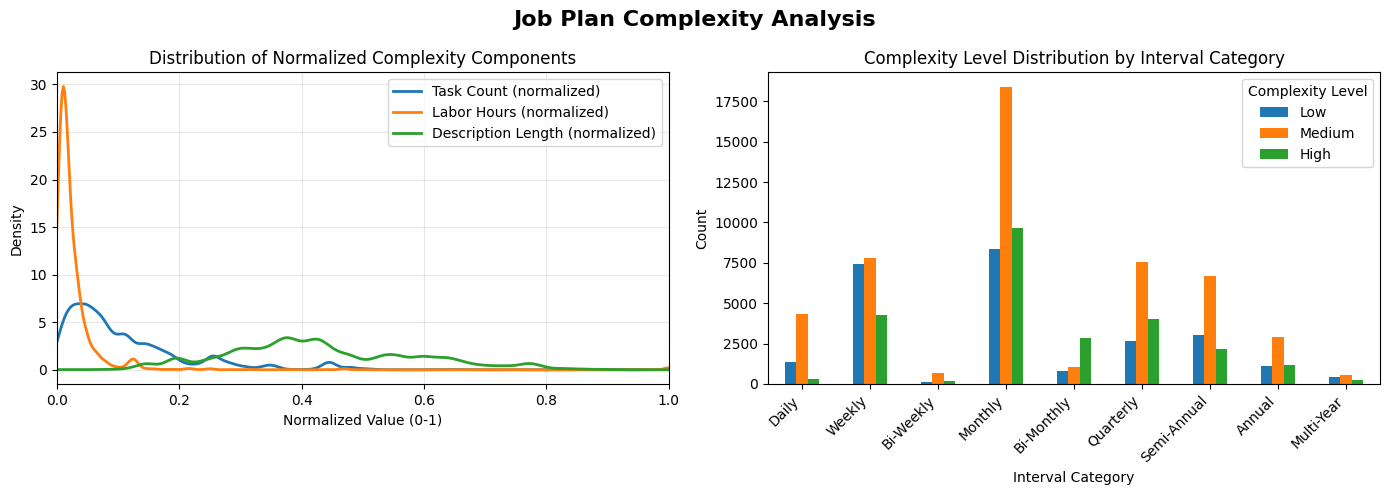

In [22]:
# Set up figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Job Plan Complexity Analysis', fontsize=16, fontweight='bold')

# Chart 1: KDE of Normalized Components
ax1 = axes[0]
df_forecast['task_norm'].plot(kind='kde', ax=ax1, linewidth=2, label='Task Count (normalized)')
df_forecast['hours_norm'].plot(kind='kde', ax=ax1, linewidth=2, label='Labor Hours (normalized)')
df_forecast['desc_norm'].plot(kind='kde', ax=ax1, linewidth=2, label='Description Length (normalized)')
ax1.set_xlabel('Normalized Value (0-1)')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of Normalized Complexity Components')
ax1.set_xlim(0, 1)
ax1.legend()
ax1.grid(alpha=0.3)

# Chart 2: Complexity Level by Interval Category
ax2 = axes[1]
complexity_by_interval = df_forecast.groupby(['interval_category', 'complexity_level'], observed = False).size().unstack(fill_value=0)
complexity_by_interval.plot(kind='bar', ax=ax2, stacked=False)
ax2.set_xlabel('Interval Category')
ax2.set_ylabel('Count')
ax2.set_title('Complexity Level Distribution by Interval Category')
ax2.legend(title='Complexity Level')
ax2.tick_params(axis='x', rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

### 3. Overall Summary Statistics and Visualization

#### 3.1 Job Type Distribution: 

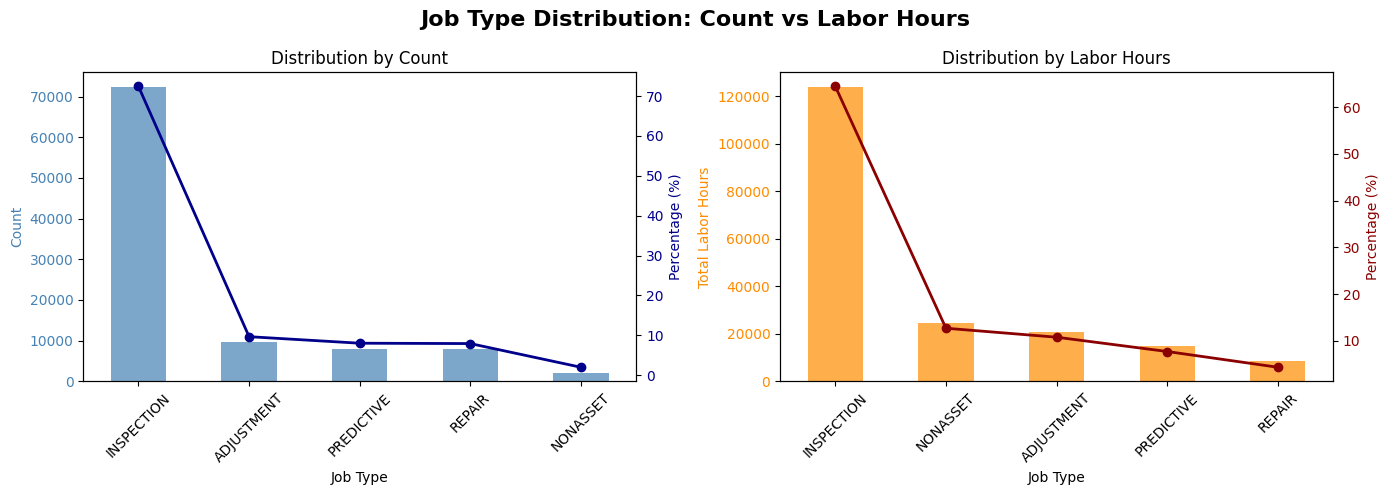


-> Job Type Summary:


,count,count_pct,total_hours,hours_pct
JOB_TYPE,,,,
ADJUSTMENT,9638,9.65,20718.533333,10.78
INSPECTION,72363,72.43,123830.066667,64.45
NONASSET,1982,1.98,24392.750000,12.70
PREDICTIVE,8007,8.01,14838.400000,7.72
REPAIR,7916,7.92,8356.133333,4.35


In [34]:
# Count and percentage of each job type
job_type_counts = df_forecast['JOB_TYPE'].value_counts().sort_values(ascending=False)
job_type_pct = (job_type_counts / job_type_counts.sum() * 100).round(2)

# Labor hours by job type
job_type_labor = df_forecast.groupby('JOB_TYPE', observed = False)['total_labor_per_occ_capped'].sum().sort_values(ascending=False)
job_type_labor_pct = (job_type_labor / job_type_labor.sum() * 100).round(2)


# Create side-by-side charts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Job Type Distribution: Count vs Labor Hours', fontsize=16, fontweight='bold')

# Chart 1: Count (bars) + Percentage (line)
ax1 = axes[0]
ax1_twin = ax1.twinx()

# Bars for count
job_type_counts.plot(kind='bar', ax=ax1, color='steelblue', alpha=0.7)
ax1.set_xlabel('Job Type')
ax1.set_ylabel('Count', color='steelblue')
ax1.set_title('Distribution by Count')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.tick_params(axis='x', rotation=45)

# Line for percentage
job_type_pct.plot(kind='line', ax=ax1_twin, color='darkblue', marker='o', linewidth=2)
ax1_twin.set_ylabel('Percentage (%)', color='darkblue')
ax1_twin.tick_params(axis='y', labelcolor='darkblue')

# Chart 2: Labor Hours (bars) + Percentage (line)
ax2 = axes[1]
ax2_twin = ax2.twinx()

# Bars for labor hours
job_type_labor.plot(kind='bar', ax=ax2, color='darkorange', alpha=0.7)
ax2.set_xlabel('Job Type')
ax2.set_ylabel('Total Labor Hours', color='darkorange')
ax2.set_title('Distribution by Labor Hours')
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.tick_params(axis='x', rotation=45)

# Line for percentage
job_type_labor_pct.plot(kind='line', ax=ax2_twin, color='darkred', marker='o', linewidth=2)
ax2_twin.set_ylabel('Percentage (%)', color='darkred')
ax2_twin.tick_params(axis='y', labelcolor='darkred')

plt.tight_layout()
plt.show()

# Print summary table
print("\n-> Job Type Summary:")
summary = pd.DataFrame({
    'count': job_type_counts,
    'count_pct': job_type_pct,
    'total_hours': job_type_labor,
    'hours_pct': job_type_labor_pct
})
display(summary)

#### 3.2  Scope Type Distribution

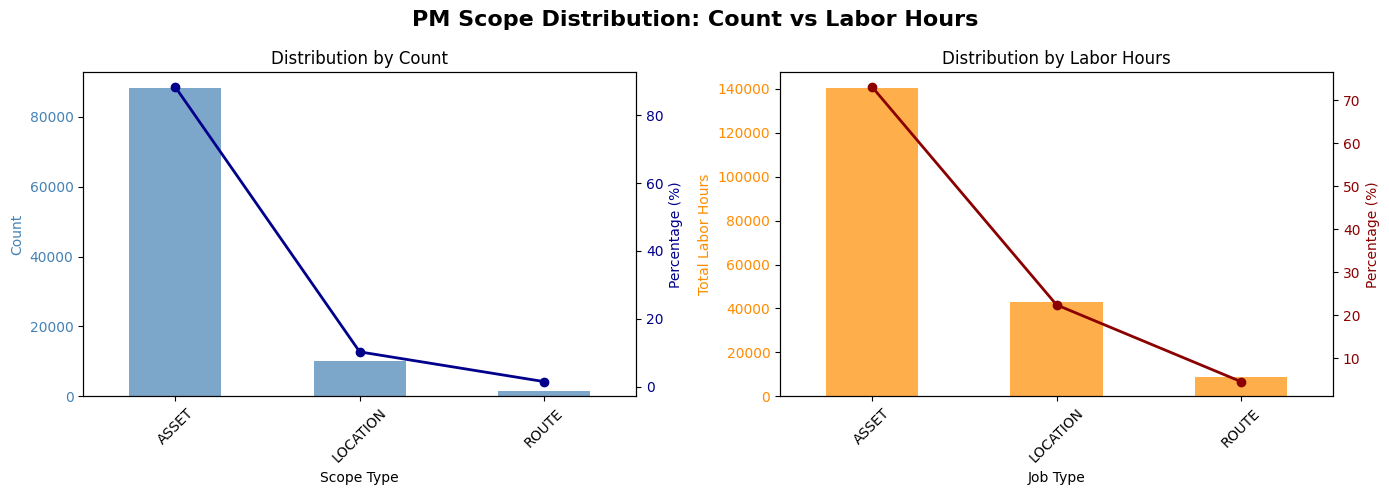


-> Scope Type Distribution:


,count,percentage,total_hours,hours_pct
PMSCOPETYPE,,,,
ASSET,88299,88.31,140502.766667,73.11
LOCATION,10225,10.23,43013.450000,22.38
ROUTE,1459,1.46,8658.166667,4.51


In [39]:
# Count and percentage
scope_counts = df_forecast['PMSCOPETYPE'].value_counts()
scope_pct = (scope_counts / scope_counts.sum() * 100).round(2)

# Labor hours by job type
scope_labor = df_forecast.groupby('PMSCOPETYPE', observed = False)['total_labor_per_occ_capped'].sum().sort_values(ascending=False)
scope_labor_pct = (scope_labor / scope_labor.sum() * 100).round(2)

# Create side-by-side charts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PM Scope Distribution: Count vs Labor Hours', fontsize=16, fontweight='bold')

# Chart 1: Count (bars) + Percentage (line)
ax1 = axes[0]
ax1_twin = ax1.twinx()

# Bars for count
scope_counts.plot(kind='bar', ax=ax1, color='steelblue', alpha=0.7)
ax1.set_xlabel('Scope Type')
ax1.set_ylabel('Count', color='steelblue')
ax1.set_title('Distribution by Count')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.tick_params(axis='x', rotation=45)

# Line for percentage
scope_pct.plot(kind='line', ax=ax1_twin, color='darkblue', marker='o', linewidth=2)
ax1_twin.set_ylabel('Percentage (%)', color='darkblue')
ax1_twin.tick_params(axis='y', labelcolor='darkblue')

# Chart 2: Labor Hours (bars) + Percentage (line)
ax2 = axes[1]
ax2_twin = ax2.twinx()

# Bars for labor hours
scope_labor.plot(kind='bar', ax=ax2, color='darkorange', alpha=0.7)
ax2.set_xlabel('Job Type')
ax2.set_ylabel('Total Labor Hours', color='darkorange')
ax2.set_title('Distribution by Labor Hours')
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.tick_params(axis='x', rotation=45)

# Line for percentage
scope_labor_pct.plot(kind='line', ax=ax2_twin, color='darkred', marker='o', linewidth=2)
ax2_twin.set_ylabel('Percentage (%)', color='darkred')
ax2_twin.tick_params(axis='y', labelcolor='darkred')

plt.tight_layout()
plt.show()


scope_summary = pd.DataFrame({
    'count': scope_counts,
    'percentage': scope_pct,
    'total_hours' : scope_labor,
    'hours_pct' : scope_labor_pct
})

print("\n-> Scope Type Distribution:")
display(scope_summary)